In [1]:
%pylab inline
import tensorflow as tf
from keras.datasets import cifar10
from tempfile import NamedTemporaryFile

from keras.utils.visualize_util import plot as keras_plot
from IPython.display import SVG, Image
from keras.utils.visualize_util import model_to_dot
import matplotlib.pyplot as plt

import shutil
import os

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


### Data

In [2]:
(train_x, train_y), (test_x, test_y) = cifar10.load_data()
train_x = train_x.astype('float32')/255.
train_y = train_y.astype('float32')

print('Train x Shape:', train_x.shape)
print('Train y Shape:', train_y.shape)

# Reshape
# train_x = train_x.reshape((len(train_x), np.prod(train_x.shape[1:3]))) # (60000, ))

print('\n[After Reshaping]')
print('Train x Shape:', train_x.shape)
print('Train y Shape:', train_y.shape)

Train x Shape: (50000, 32, 32, 3)
Train y Shape: (50000, 1)

[After Reshaping]
Train x Shape: (50000, 32, 32, 3)
Train y Shape: (50000, 1)


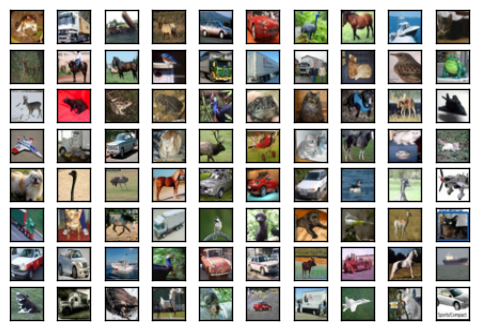

In [3]:
def display(images, size=80):
    for i in range(size):
        ax = subplot(size/10, 10, i+1)
        ax.imshow(images[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
display(train_x[:80])

### Model

In [4]:
encoding_dim1 = 1024
encoding_dim2 = 512
encoding_dim3 = 256

# Input Layers
input1 = tf.placeholder('float', shape=(None, 32, 32, 3), name='Input')
input2 = tf.reshape(input1, [-1, 3072])


# Weights and Biases
weights = {
    'encoder1': tf.Variable(tf.random_normal([3072, encoding_dim1]), name='Encoded1'),
    'encoder2': tf.Variable(tf.random_normal([encoding_dim1, encoding_dim2]), name='Encoded2'),
    'encoder3': tf.Variable(tf.random_normal([encoding_dim2, encoding_dim3]), name='Encoded3'),
    
    'decoder1': tf.Variable(tf.random_normal([encoding_dim3, encoding_dim2]), name='Decoded1'),
    'decoder2': tf.Variable(tf.random_normal([encoding_dim2, encoding_dim1]), name='Decoded2'),
    'decoder3': tf.Variable(tf.random_normal([encoding_dim1, 3072]), name='Decoded3')
}

biases = {
    'encoder_b1': tf.Variable(tf.random_normal([encoding_dim1])),
    'encoder_b2': tf.Variable(tf.random_normal([encoding_dim2])),
    'encoder_b3': tf.Variable(tf.random_normal([encoding_dim3])),
    
    'decoder_b1': tf.Variable(tf.random_normal([encoding_dim2])),
    'decoder_b2': tf.Variable(tf.random_normal([encoding_dim1])),
    'decoder_b3': tf.Variable(tf.random_normal([3072]))
}


# Encoder
def encoder_model():
    layer1 = tf.nn.sigmoid(tf.add(tf.matmul(input2, weights['encoder1']), biases['encoder_b1']))
    layer2 = tf.nn.sigmoid(tf.add(tf.matmul(layer1, weights['encoder2']), biases['encoder_b2']))
    layer3 = tf.nn.sigmoid(tf.add(tf.matmul(layer2, weights['encoder3']), biases['encoder_b3']))
    return layer3
encoder_op = encoder_model()

# Decoder
def decoder_model():
    layer1 = tf.nn.sigmoid(tf.add(tf.matmul(encoder_op, weights['decoder1']), biases['decoder_b1']))
    layer2 = tf.nn.sigmoid(tf.add(tf.matmul(layer1, weights['decoder2']), biases['decoder_b2']))
    layer3 = tf.nn.sigmoid(tf.add(tf.matmul(layer2, weights['decoder3']), biases['decoder_b3']))
    layer4 = tf.reshape(layer3, [-1, 32, 32, 3])
    return layer4
decoder_op = decoder_model()

# Cost function and Gradient Descent 
cost = tf.reduce_mean(tf.pow(input1 - decoder_op, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate=0.01).minimize(cost)

### Tensorboard

```
tensorboard --logdir=/tmp/autoencoder.tensorflow --reload_interval=5
```

In [5]:
if os.path.exists('/tmp/autoencoder.tensorflow'):
    shutil.rmtree('/tmp/autoencoder.tensorflow')
cost_summary = tf.Summary()

### Training

In [6]:
TOTAL_BATCH = train_x.shape[0]
BATCH_SIZE = 100

def next_batch(X, step, batch_size=BATCH_SIZE):
    index = batch_size * step
    return X[index:index + batch_size]

def shuffle(X):
    permutation = np.random.permutation(len(X))
    return X[permutation]

In [7]:
# Initialization
global_step = 0

init_op = tf.global_variables_initializer()
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.4, allow_growth=True)

sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
sess.run(init_op)

# Tensorboard
writer = tf.summary.FileWriter('/tmp/autoencoder.tensorflow', graph=sess.graph)

In [8]:
for episode in range(20):
    avg_cost = 0
    for step in range(int(train_x.shape[0]/BATCH_SIZE) ):
        sample_x = next_batch(train_x, step, batch_size=BATCH_SIZE)

        _, c = sess.run([optimizer, cost], 
                        feed_dict={input1: sample_x})

        cost_summary.value.add(tag='cost', simple_value=float(c))
        if step%1000 == 0:
            writer.add_summary(cost_summary, global_step=global_step)

        avg_cost += c
        global_step += 1
    train_x = shuffle(train_x)
    print('Episode:', episode, ', cost:', round(avg_cost/step, 6))

Episode: 0 , cost: 0.276047
Episode: 1 , cost: 0.245273
Episode: 2 , cost: 0.239019
Episode: 3 , cost: 0.236343
Episode: 4 , cost: 0.234828
Episode: 5 , cost: 0.233059
Episode: 6 , cost: 0.231769
Episode: 7 , cost: 0.230905
Episode: 8 , cost: 0.229105
Episode: 9 , cost: 0.228068
Episode: 10 , cost: 0.227685
Episode: 11 , cost: 0.228343
Episode: 12 , cost: 0.227245
Episode: 13 , cost: 0.226797
Episode: 14 , cost: 0.226211
Episode: 15 , cost: 0.226263
Episode: 16 , cost: 0.227326
Episode: 17 , cost: 0.226983
Episode: 18 , cost: 0.226372
Episode: 19 , cost: 0.226358


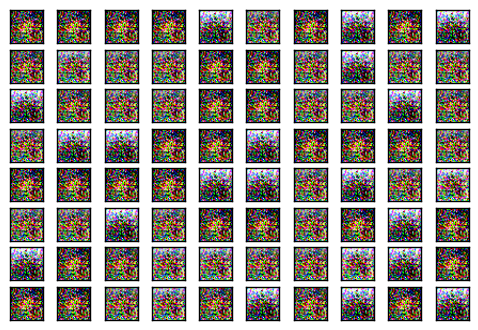

In [9]:
SAMPLE_BATCH_SIZE = 80

sample_x = next_batch(train_x, 0, batch_size=SAMPLE_BATCH_SIZE)
# encoded_samples = sess.run(encoder_op, feed_dict={input1: sample_x})

decoded_samples = sess.run(decoder_op, feed_dict={input1: sample_x})
display(decoded_samples)

### Save Weights

In [ ]:
if not os.path.exists('_tfmodel'):
    os.mkdir('_tfmodel')

weights_saver = tf.train.Saver(var_list=weights)
biases_saver = tf.train.Saver(var_list=biases)

weights_saver.save(sess, '_tfmodel/autoencoder.weights')
biases_saver.save(sess, '_tfmodel/autoencoder.biases')